In [1]:
# this notebook was largely taken from  this one: https://www.kaggle.com/code/mrdheer/one-stop-destination-for-asteroids-classification/notebook

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from xgboost import plot_tree

In [3]:
# load the data
original = pd.read_csv('/home/sylvanix/data/asteroids.csv')
df=original.copy()

/tmp/ipykernel_59632/3380868365.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  original = pd.read_csv('/home/sylvanix/data/asteroids.csv')


In [4]:
df.head()

id    spkid       full_name pdes     name prefix neo pha     H   
0  a0000001  2000001         1 Ceres    1    Ceres    NaN   N   N  3.40  \
1  a0000002  2000002        2 Pallas    2   Pallas    NaN   N   N  4.20   
2  a0000003  2000003          3 Juno    3     Juno    NaN   N   N  5.33   
3  a0000004  2000004         4 Vesta    4    Vesta    NaN   N   N  3.00   
4  a0000005  2000005       5 Astraea    5  Astraea    NaN   N   N  6.90   

   diameter  ...       sigma_i      sigma_om       sigma_w      sigma_ma   
0   939.400  ...  4.608900e-09  6.168800e-08  6.624800e-08  7.820700e-09  \
1   545.000  ...  3.469400e-06  6.272400e-06  9.128200e-06  8.859100e-06   
2   246.596  ...  3.223100e-06  1.664600e-05  1.772100e-05  8.110400e-06   
3   525.400  ...  2.170600e-07  3.880800e-07  1.789300e-07  1.206800e-06   
4   106.699  ...  2.740800e-06  2.894900e-05  2.984200e-05  8.303800e-06   

       sigma_ad       sigma_n      sigma_tp     sigma_per  class      rms  
0  1.111300e-11  1.196500e-12  3.782900e-08  9.415900e-09    MBA  0.43301  
1  4.961300e-09  4.653600e-10  4.078700e-05  3.680700e-06    MBA  0.35936  
2  4.363900e-09  4.413400e-10  3.528800e-05  3.107200e-06    MBA  0.33848  
3  1.648600e-09  2.612500e-10  4.103700e-06  1.274900e-06    MBA  0.39980  
4  4.729000e-09  5.522700e-10  3.474300e-05  3.490500e-06    MBA  0.52191  

[5 rows x 45 columns]

## Data Preprocessing

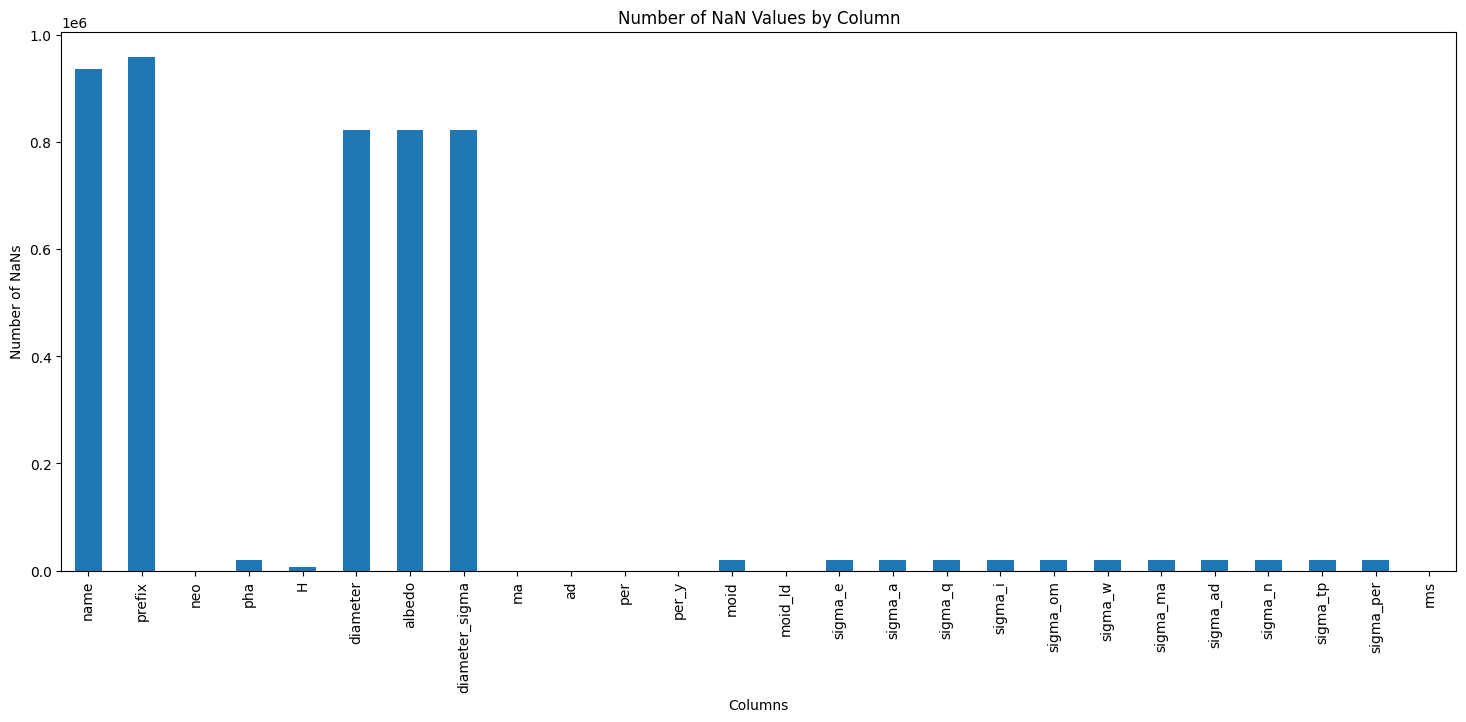

In [5]:
nan_counts = df.isnull().sum()

# filter nan_counts to include only columns with non-zero NaN counts
nan_counts_filtered = nan_counts[nan_counts > 0]

# bar chart of filtered NaN counts
plt.figure(figsize=(18, 7))
nan_counts_filtered.plot(kind='bar')
plt.title('Number of NaN Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.show()

In [6]:
# Columns with missing values in %
missing_cols = df.isna().mean() * 100
missing_cols = missing_cols[missing_cols > 0]
print("Percentage of missing values:\n", missing_cols)

Percentage of missing values:
 name              97.698128
prefix            99.998122
neo                0.000417
pha                2.078300
H                  0.653400
diameter          85.789714
albedo            85.905100
diameter_sigma    85.803068
ma                 0.000104
ad                 0.000417
per                0.000417
per_y              0.000104
moid               2.078300
moid_ld            0.013250
sigma_e            2.078404
sigma_a            2.078404
sigma_q            2.078404
sigma_i            2.078404
sigma_om           2.078404
sigma_w            2.078404
sigma_ma           2.078404
sigma_ad           2.078821
sigma_n            2.078404
sigma_tp           2.078404
sigma_per          2.078821
rms                0.000209
dtype: float64


In [7]:
# Check for missing values in the "H" attribute
missing = df['H'].isna()

# Prepare the data for Little's MCAR test
observed = np.array([sum(~missing), sum(missing)])
expected = np.array([len(df) * (1 - np.mean(missing)), len(df) * np.mean(missing)])

# Conduct the test and calculate the p-value
chi2, p_value = stats.chisquare(observed, f_exp=expected)
print(p_value)
# Interpret the results
if p_value < 0.05:
    print("The missing data mechanism for 'H' is not MCAR.")
else:
    print("The missing data mechanism for 'H' is MCAR.")


1.0
The missing data mechanism for 'H' is MCAR.


In [8]:
# We could perform the MCAR test for the other NaNs columns as well... 

In [9]:
# remove columns which will not facilitate the analysis
no_null_data=df.drop(['pdes', 'name', 'prefix', 'diameter', 'albedo', 'diameter_sigma'], axis=1)

# remove the rows that includes null value
no_null_data=no_null_data.dropna().reset_index(drop=True)

# convert data type of column "spkid"
no_null_data['spkid'] = no_null_data['spkid'].astype(str)


## Exploratory Data Analysis (EDA), part 1

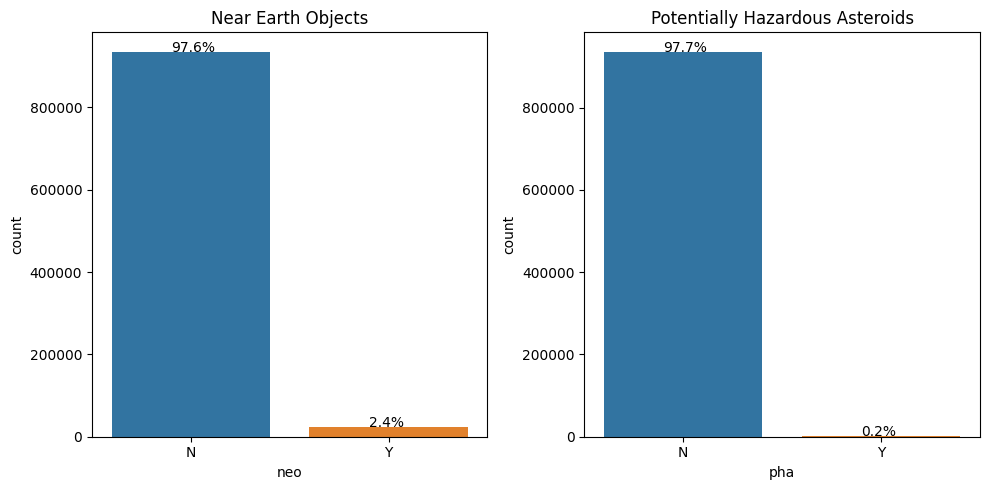

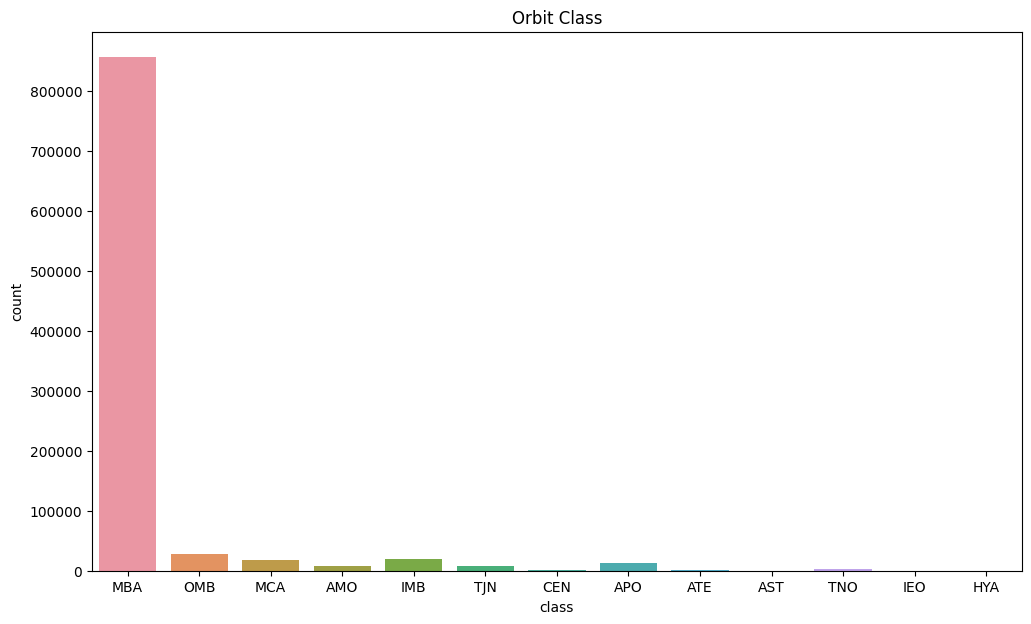

In [10]:
# figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# count plot of the "neo" variable on the left subplot
sns.countplot(x='neo', data=df, ax=axs[0])
axs[0].set_title('Near Earth Objects')

# add percentage labels to the left subplot
total = float(len(df.neo))
for p in axs[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 3
    axs[0].annotate(percentage, (x, y))

#  count plot of the "pha" variable on the right subplot
sns.countplot(x='pha', data=df, ax=axs[1])
axs[1].set_title('Potentially Hazardous Asteroids')

# add percentage labels to the right subplot
total = float(len(df.pha))
for p in axs[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 3
    axs[1].annotate(percentage, (x, y))

# adjust the spacing between the subplots
fig.tight_layout()

plt.show()

# count plot for Orbit Class
fig, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='class', data=df, ax=ax)
plt.title('Orbit Class')

plt.show()

The dataset is highly unbalanced.  
2.4% of objects are "Near Earth Objects", and out of those only 0.2% are "Hazardous Asteriods".  
Out of 12 Orbit classes most are "MBA", around 89%.  

## More data preprocessing

In [11]:
from sklearn.calibration import LabelEncoder

# remove identifying columns
data=no_null_data.drop(['id', 'spkid', 'full_name', 'orbit_id', 'equinox'], axis=1).reset_index(drop=True)

# encode categorical features and target
one_hot_encoded_data = pd.get_dummies(data, columns=['neo', 'class'])
one_hot_encoded_data['pha'] = LabelEncoder(
).fit_transform(one_hot_encoded_data['pha'])

from sklearn.model_selection import train_test_split

# split train, validation, and test sets
x = one_hot_encoded_data.drop('pha', axis=1)
y = one_hot_encoded_data['pha'].to_frame()
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.4, random_state=100, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=100, stratify=y_test)
print("Shape of original dataset :", one_hot_encoded_data.shape)
print("Shape of x_train set", x_train.shape)
print("Shape of y_train set", y_train.shape)
print("Shape of x_validation set", x_val.shape)
print("Shape of y_validation set", y_val.shape)
print("Shape of x_test set", x_test.shape)
print("Shape of y_test set", y_test.shape)

from sklearn.preprocessing import StandardScaler

# Normalize the features (normalizing after splitting could prevent leaking information
#    about the validation set into the train set)
# StandardScaler() is useful in classification and Normalizer() is useful in regression
x_train = StandardScaler().fit_transform(x_train)
x_val = StandardScaler().fit_transform(x_val)
x_test = StandardScaler().fit_transform(x_test)

# Imbalance in target variable
y_train.value_counts()

Shape of original dataset : (932335, 46)
Shape of x_train set (559401, 45)
Shape of y_train set (559401, 1)
Shape of x_validation set (186467, 45)
Shape of y_validation set (186467, 1)
Shape of x_test set (186467, 45)
Shape of y_test set (186467, 1)


pha
0      558161
1        1240
Name: count, dtype: int64

## Fix the Imbalance with SMOTE and RandomUnderSampler

In [12]:
from imblearn.over_sampling import SMOTE

# Data Upsampling - SMOTE
x_train_us, y_train_us = SMOTE(
    sampling_strategy=0.5, random_state=100).fit_resample(x_train, y_train)
y_train_us.value_counts()

from imblearn.under_sampling import RandomUnderSampler

# Random Undersampling
random_under_sampling = RandomUnderSampler(random_state=100)
x_train_us_rus, y_train_us_rus = random_under_sampling.fit_resample(x_train_us, y_train_us)

y_train_us_rus.value_counts()

from imblearn.over_sampling import SMOTE

# Upsampling - SMOTE
x_train_SMOTE, y_train_SMOTE = SMOTE(
    sampling_strategy=0.5, random_state=100).fit_resample(x_train, y_train)
y_train_SMOTE.value_counts()

# Random Undersampling
random_under_SAMPLING = RandomUnderSampler(random_state=100)
x_train_us_UNDER, y_train_us_UNDER = random_under_SAMPLING.fit_resample(x_train_SMOTE, y_train_SMOTE)


y_train_us_UNDER['pha'] = y_train_us_UNDER['pha'].map({0: 'N', 1: 'Y'})

ax = sns.countplot(x="pha", data=y_train_us_UNDER)
total = float(len(y_train_us_UNDER))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:.2f}%'.format(100*height/total), ha="center")
plt.show()

## Machine Learning Models

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


rfc = RandomForestClassifier(class_weight='balanced', random_state=100)
# Skip Hyperparameter Tuning part because parameter with dafult value get the highest accuracy of model

rfc.fit(x_train_us_rus, np.ravel(y_train_us_rus))

# Predict for validation set
y_val_pred = rfc.predict(x_val)

# Metrics
precision_rfc, recall_rfc, fscore_rfc, support_rfc = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro'
)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.98      0.43      0.60       413

    accuracy                           1.00    186467
   macro avg       0.99      0.71      0.80    186467
weighted avg       1.00      1.00      1.00    186467



## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
lr = LogisticRegression(max_iter=100)

lr.fit(x_train_us_rus, np.ravel(y_train_us_rus))
# predict for validation set
y_val_pred = lr.predict(x_val)

# metrics
precision_lr, recall_lr, fscore_lr, support_lr = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro')
print(classification_report(y_val, y_val_pred))

/home/sylvanix/.py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    186054
           1       0.25      1.00      0.40       413

    accuracy                           0.99    186467
   macro avg       0.62      1.00      0.70    186467
weighted avg       1.00      0.99      1.00    186467



## Decision Tree

In [15]:
dtc=DecisionTreeClassifier(class_weight='balanced', random_state=100)

dtc.fit(x_train_us_rus, y_train_us_rus)
# Predict for validation set
y_val_pred=dtc.predict(x_val)

# Metrics
precision_dtc, recall_dtc, fscore_dtc, support_dtc = precision_recall_fscore_support(y_val, y_val_pred, average='macro')
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.94      0.43      0.59       413

    accuracy                           1.00    186467
   macro avg       0.97      0.72      0.80    186467
weighted avg       1.00      1.00      1.00    186467



## Naive Bayes Classifier

In [16]:
gnb=GaussianNB()

gnb.fit(x_train_us_rus, np.ravel(y_train_us_rus))
# Predict for validation set
y_val_pred=gnb.predict(x_val)

# Metrics
precision_gnb, recall_gnb, fscore_gnb, support_gnb=precision_recall_fscore_support(y_val, y_val_pred, average='macro')
print (classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.00      0.00      0.00       413

    accuracy                           1.00    186467
   macro avg       0.50      0.50      0.50    186467
weighted avg       1.00      1.00      1.00    186467



## XG Boost

In [17]:
from xgboost import XGBClassifier


xgbc = XGBClassifier(max_depth=10, learning_rate=0.1,
                     n_estimators=1000, eval_metric='mlogloss', random_state=100)

# Train the model on the training set
xgbc.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = xgbc.predict(x_test)

# Calculate precision, recall, and f1 score
precision_xgbc = precision_score(y_test, y_pred)
recall_xgbc = recall_score(y_test, y_pred)
fscore_xgbc = f1_score(y_test, y_pred)

# Print precision, recall, and f1 score
print(f"Precision: {precision_xgbc:.2f}")
print(f"Recall: {recall_xgbc:.2f}")
print(f"F1 score: {fscore_xgbc:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

Precision: 0.97
Recall: 0.14
F1 score: 0.25
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.97      0.14      0.25       413

    accuracy                           1.00    186467
   macro avg       0.98      0.57      0.62    186467
weighted avg       1.00      1.00      1.00    186467



## KNN

In [ ]:
knc=KNeighborsClassifier(n_neighbors=1)
knc.fit(x_train_us_rus, np.ravel(y_train_us_rus))
# Predict for test set
y_test_pred=knc.predict(x_test)

# Metrics
precision_knc, recall_knc, fscore_knc, support_knc=precision_recall_fscore_support(y_test, y_test_pred, average='macro')
print(classification_report(y_test, y_test_pred))

## Neural Network

In [ ]:
# ...

## Model Comparison

In [ ]:
Model_Selection=pd.DataFrame({'Model':['Random Forest', 'XGBoost', 'Decision Tree', 'Navie Bayes', 'Logistic Regression', 'K-Nearest Neighbors'],
                              'Precision':[precision_rfc, precision_xgbc, precision_dtc, precision_gnb, precision_lr,  precision_knc],
                              'Recall':[recall_rfc, recall_xgbc, recall_dtc, recall_gnb, recall_lr,  recall_knc],
                              'F1 Score':[fscore_rfc, fscore_xgbc, fscore_dtc, fscore_gnb, fscore_lr,  fscore_knc],
                              })
Model_Selection.index+=1
Model_Selection